# Getting started

A lot of people get diagnosed with squamous cell carcinoma in the head & neck region ([HNSCC](https://en.wikipedia.org/wiki/Head_and_neck_cancer)), which frequently metastasizes via the lymphatic system. We set out to develop a methodology to predict the risk of a new patient having metastases in so-called lymph node levels (LNLs), based on their personal diagnose (e.g. findings from a CT scan) and information of previously diagnosed and treated patients. And that's exactly what this code enables you to do as well.

As mentioned, this package is meant to be a relatively simple-to-use frontend. The math is done under the hood and one does not need to worry about it a lot. But let's have a quick look at what we're doing here.

We will assume that you have already read the section on how to install the module and followed its instructions.

## Importing

First, let's import the package.

In [1]:
import lymph

## Graph

The model is based on the assumption that one can represent the lymphatic system as a directed graph. The arcs in that graph represent the direction of the lymphatic flow and therefore also the direction of metastatic spread. Hence, the first thing to do is to define a graph that represents the drainage pathways of the lymphatic system aptly.

Here, this is done via a dictionary:

In [2]:
graph = {
    ('tumor', 'primary')  : ['I', 'II', 'III', 'IV'], 
    ('lnl'  , 'I')  :       ['II'], 
    ('lnl'  , 'II') :       ['III'], 
    ('lnl'  , 'III'):       ['IV'], 
    ('lnl'  , 'IV') :       []
}

Every key in this dictionary is a tuple of the form `({type}, {name})` and represents either a tumor - in which case the `{type}` must be `'tumor'` - or a lymph node level (`{type}` must be `'lnl'`). The value of each of those nodes is then a list of names for nodes it connects to. So, for example the primary tumor `('tumor', 'primary')` in the `graph` above has directed arcs to `a` and `b`, while the LNL `c` does not have any outgoing connections.

We can simply create an instance of `System` using only this graph and let it report itself:

In [4]:
unilateral_model = lymph.models.Unilateral(graph=graph)
print(unilateral_model)

Unilateral with 1 tumors and 4 LNLs


The percentages between two nodes represents the probability rate that metastatic spread occurs along it. In the case of the tumor spreading to LNL `a` we call this probability *base probability rate* $\tilde{b}_a$. For the spread between lymph node levels, we call it *transition probability rate*, e.g. $\tilde{t}_{ab}$. The difference to the base probability rate is that it only plays a role if the parent LNL is already ivolved with metastases, while the tumor always spreads, of course.

We can change these spread probability rates either via the lookup dictionary `edge_params`, or via the method `assign_parms()`, which also handles parameters not related to the spread probability rates of the arcs between LNLs. In the former case, the keys to set the spread probabilities are built like `"spread_" + parent.name + "_to_" + child.name`.

In [6]:
unilateral_model.edge_params["spread_primary_to_II"].set(0.5)
print(unilateral_model.edge_params["spread_primary_to_II"].get())

0.5


In [7]:
unilateral_model.assign_params(spread_II_to_III=0.25)
print(unilateral_model.get_params(as_dict=True))

{'spread_primary_to_I': 0.0, 'spread_primary_to_II': 0.5, 'spread_primary_to_IV': 0.0, 'spread_primary_to_III': 0.0, 'spread_I_to_II': 0.0, 'spread_II_to_III': 0.25, 'spread_III_to_IV': 0.0}


## Diagnostic Modalities

To ultimately compute the likelihoods of observations, we need to fix the sensitivities and specificities of the obtained diagnoses. And since we might have multiple diagnostic modalities available, we need to tell the system which of them comes with which specificity and sensitivity. We do this by creating a dictionary of specificity/sensitivity pairs:

In [8]:
mri_and_pet_spsn = {"MRI": [0.63, 0.81], 
                    "PET": [0.86, 0.79]}
#                           ^     ^
#                  specificty     sensitivity

Now we can pass this to the system by setting the `modalities` attribute, which expects a dictionary containing the diagnostic modalities and as a key to it the numbers for specificity & sensitivity.

In [9]:
unilateral_model.modalities = mri_and_pet_spsn

## Data / Observations

To compute the likelihood of a set of probability (rates) given a patient cohort we need such a patient cohort, of course. We can provide it to the system in the form of a `pandas` `DataFrame`. Here is an example:

In [14]:
import pandas as pd

dataset_url = "https://raw.githubusercontent.com/rmnldwg/lydata/main/2021-usz-oropharynx/data.csv"

usz_oropharynx = pd.read_csv(dataset_url, header=[0,1,2])
usz_oropharynx

patient                                                                    \
          #                                                                     
         id     sex age diagnose_date alcohol_abuse nicotine_abuse hpv_status   
0         1    male  59    30/08/2017          True           True       True   
1         2  female  75    25/10/2017         False          False       True   
2         3    male  87    03/04/2018         False           True       True   
3         4    male  87    16/04/2018          True           True      False   
4         5  female  70    25/05/2018          True           True       True   
..      ...     ...  ..           ...           ...            ...        ...   
282     283    male  49    28/07/2013         False           True      False   
283     284    male  67    19/09/2013          True           True       True   
284     285    male  44    29/06/2013          True           True      False   
285     286    male  67    04/07/2013          True           True      False   
286     287    male  76    02/07/2013         False           True       True   

                                         ... pathology                      \
                                         ...      ipsi                       
    neck_dissection tnm_edition n_stage  ...       IIa  IIb  III   IV    V   
0             False           8       1  ...       NaN  NaN  NaN  NaN  NaN   
1             False           8       1  ...       NaN  NaN  NaN  NaN  NaN   
2             False           7       2  ...       NaN  NaN  NaN  NaN  NaN   
3             False           8       3  ...       NaN  NaN  NaN  NaN  NaN   
4             False           7       2  ...       NaN  NaN  NaN  NaN  NaN   
..              ...         ...     ...  ...       ...  ...  ...  ...  ...   
282           False           7       1  ...       NaN  NaN  NaN  NaN  NaN   
283           False           7       2  ...       NaN  NaN  NaN  NaN  NaN   
284           False           7       2  ...       NaN  NaN  NaN  NaN  NaN   
285           False           7       2  ...       NaN  NaN  NaN  NaN  NaN   
286           False           7       2  ...       NaN  NaN  NaN  NaN  NaN   

                          
                          
     VI VII VIII  IX   X  
0   NaN NaN  NaN NaN NaN  
1   NaN NaN  NaN NaN NaN  
2   NaN NaN  NaN NaN NaN  
3   NaN NaN  NaN NaN NaN  
4   NaN NaN  NaN NaN NaN  
..   ..  ..  ...  ..  ..  
282 NaN NaN  NaN NaN NaN  
283 NaN NaN  NaN NaN NaN  
284 NaN NaN  NaN NaN NaN  
285 NaN NaN  NaN NaN NaN  
286 NaN NaN  NaN NaN NaN  

[287 rows x 193 columns]

Note that this data has three header-rows. It follows the standard of the data presented in the interactive dashboard [LyProX]. It can be obtained from the [lyDATA] repository on GitHub and is described in more detail [here].

[LyProX]: https://lyprox.org
[lyDATA]: https://github.com/rmnldwg/lydata
[here]: https://github.com/rmnldwg/lydata/tree/main/2021-usz-oropharynx

In [17]:
unilateral_model.modalities = {"CT": [0.86, 0.81]}

To feed the dataset into the system, we assign the dataset to the attribute `patient_data`. What the system then does here is creating a diagnose matrix for every T-stage in the data.

In [18]:
unilateral_model.load_patient_data(usz_oropharynx, side="ipsi")
unilateral_model.patient_data

patient                                                                    \
          #                                                                     
         id     sex age diagnose_date alcohol_abuse nicotine_abuse hpv_status   
0         1    male  59    30/08/2017          True           True       True   
1         2  female  75    25/10/2017         False          False       True   
2         3    male  87    03/04/2018         False           True       True   
3         4    male  87    16/04/2018          True           True      False   
4         5  female  70    25/05/2018          True           True       True   
..      ...     ...  ..           ...           ...            ...        ...   
282     283    male  49    28/07/2013         False           True      False   
283     284    male  67    19/09/2013          True           True       True   
284     285    male  44    29/06/2013          True           True      False   
285     286    male  67    04/07/2013          True           True      False   
286     287    male  76    02/07/2013         False           True       True   

                                         ... pathology                   \
                                         ...      ipsi                    
    neck_dissection tnm_edition n_stage  ...        VI VII VIII  IX   X   
0             False           8       1  ...       NaN NaN  NaN NaN NaN   
1             False           8       1  ...       NaN NaN  NaN NaN NaN   
2             False           7       2  ...       NaN NaN  NaN NaN NaN   
3             False           8       3  ...       NaN NaN  NaN NaN NaN   
4             False           7       2  ...       NaN NaN  NaN NaN NaN   
..              ...         ...     ...  ...       ...  ..  ...  ..  ..   
282           False           7       1  ...       NaN NaN  NaN NaN NaN   
283           False           7       2  ...       NaN NaN  NaN NaN NaN   
284           False           7       2  ...       NaN NaN  NaN NaN NaN   
285           False           7       2  ...       NaN NaN  NaN NaN NaN   
286           False           7       2  ...       NaN NaN  NaN NaN NaN   

    _model                              
        CT                           #  
         I    II    III     IV t_stage  
0      NaN   NaN    NaN    NaN    late  
1      NaN   NaN    NaN    NaN   early  
2      NaN   NaN    NaN    NaN    late  
3      NaN   NaN    NaN    NaN    late  
4      NaN   NaN    NaN    NaN   early  
..     ...   ...    ...    ...     ...  
282   True  True  False  False    late  
283    NaN   NaN    NaN    NaN    late  
284    NaN   NaN    NaN    NaN    late  
285    NaN   NaN    NaN    NaN    late  
286    NaN   NaN    NaN    NaN   early  

[287 rows x 198 columns]

Note that the data now has an additional top-level header `"_model"` which stores only the information the model actually needs. In this case, it only stores the ipsilateral CT diagnoses of the LNLs I, II, III, and IV, as well as the mapped T-stage of the patients. Note that from the original T-stages 1, 2, 3, and 4, only "early" and "late" are left. This is the default transformation, but it can be changed by providing a function to the `mapping` keyword argument in the `load_patient_data()` method.

## Distribution over Diagnose Times

The last ingredient to set up (at least when using the hidden Markov model) would now be the distribution over diagnose times. Our dataset contains two different T-stages "early" and "late". One of the underlying assumptions with our model is that earlier T-stage patients have been - on average - diagnosed at an earlier time-point, compared to late T-stage patients. We can reflect that using distributions over the diagnosis time:

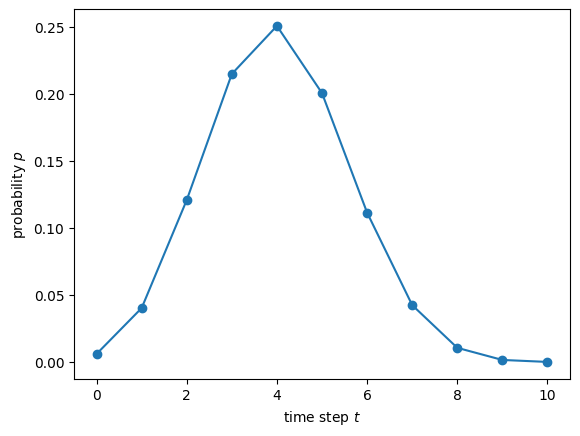

In [11]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt

max_t = 10
time_steps = np.arange(max_t+1)
p = 0.4

early_prior = sp.stats.binom.pmf(time_steps, max_t, p)

plt.plot(time_steps, early_prior, "o-");
plt.xlabel("time step $t$");
plt.ylabel("probability $p$");

In [12]:
unilateral_model.diag_time_dists["early"] = early_prior

## Likelihood

With everything set up like this, we can compute the likelihood of seeing the above dataset given a set of base and transition probability (rates).

In [13]:
test_probabilities = np.array([0.02, 0.24, 0.03, 0.2, 0.23, 0.18, 0.18])

llh = unilateral_model.likelihood(given_params=test_probabilities, log=True)

print(f"log-likelihood is {llh:.2f}")

log-likelihood is -331.09


In [14]:
print(unilateral_model)

Unilateral lymphatic system with 1 tumor(s) and 4 LNL(s).
primary-2.0%->I primary-24.0%->II primary-3.0%->III primary-20.0%->IV I-23.0%->II II-18.0%->III III-18.0%->IV


From here it is up to the user what to do with this quantity. Most *likely* though, one would want to perform MCMC sampling with this.

## Summary

To set up a model for lymphatic metastatic spread, you need to do the following things:

1. Define a graph that connects the lymph node levels via a dictionary
2. Provide the specificity & sensitivity of the diagnostic modalities to the `modalities` attribute
3. Assign your correctly formatted pandas `DataFrame` to the attribute `patient_data` of the model
4. For each T-stage in the data, define a distribution over possible diagnose times

Then, you can use the `log_likelihood` method to compute the log-likelihood of the stored data given an array of parameters - the spread probabilities.